In [1]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [2]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [3]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e18.pth'

In [5]:
cfg.merge_from_file(fn_config)
cfg.TRACK.LR = 0.1
cfg.TRACK.WINDOW_INFLUENCE = 0.42

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [6]:
# test image sequence
test_name = 'basketball'

path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000009'
fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000009/groundtruth.txt'
# path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
# fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [7]:
def _iou(lhs, rhs):
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return I / (A - I)

In [ ]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
    
    break
    
#     if ii > 10:
#         break
    
    if iou < 0.3:
        print('Miss at frame {}'.format(ii))
        break

    plt.imshow(t_img[:, :, ::-1])
    rect = plt.Rectangle((rbb[0], rbb[1]),
                         rbb[2],
                         rbb[3], fill=False,
                         edgecolor=[1, 0, 0], linewidth=3.5)
    plt.gca().add_patch(rect)
    
    gtbb = gt_seq[ii]
    rect = plt.Rectangle((gtbb[0], gtbb[1]),
                         gtbb[2],
                         gtbb[3], fill=False,
                         edgecolor=[0, 1, 0], linewidth=2.5)
    plt.gca().add_patch(rect)
    plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
    plt.clf()

Tracking started, total 100 frames.
> /home/hyunjoon/github/tracking-pytorch/pysot/tracker/siamcar_tracker.py(150)track()
    149         ipdb.set_trace()
--> 150         pscore = penalty * score * centerness
    151 



ipdb>  pred_bbox


array([[119.39594 , 118.83333 , 315.33707 ,  15.297718],
       [128.366   , 118.014275, 140.28201 ,  29.11479 ],
       [113.37839 , 117.06196 , 226.6091  ,  17.705126],
       [136.12692 , 118.483795, 205.11023 ,  24.206676],
       [118.18931 , 125.19471 , 314.5978  ,  14.671949],
       [123.882515, 111.76058 , 270.79453 ,  18.317034],
       [137.95007 , 112.58344 , 243.80699 ,  20.671362],
       [142.56703 , 118.17589 , 123.80328 ,  33.898746]], dtype=float32)


ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/tracker/siamcar_tracker.py(156)track()
    155         #     self.window * cfg.TRACK.WINDOW_INFLUENCE
--> 156         best_idx = np.argmax(pscore)
    157 



ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/tracker/siamcar_tracker.py(160)track()
    159         # ipdb.set_trace()
--> 160         bbox = pred_bbox[best_idx, :]
    161         # bbox[:2] += cfg.TRACK.INSTANCE_SIZE / 2.0



ipdb>  best_idx


5


ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/tracker/siamcar_tracker.py(163)track()
    162         # iou = IoU(center2corner(bbox), center2corner(np.transpose(self.anchors)))
--> 163         bbox /= scale_z
    164         lr = penalty[best_idx] * score[best_idx] * cfg.TRACK.LR



ipdb>  bbox


array([123.882515, 111.76058 , 270.79453 ,  18.317034], dtype=float32)


ipdb>  scale_z


0.15095865900805716


ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/tracker/siamcar_tracker.py(164)track()
    163         bbox /= scale_z
--> 164         lr = penalty[best_idx] * score[best_idx] * cfg.TRACK.LR
    165 



ipdb>  scale_z


0.15095865900805716


ipdb>  bbox


array([ 820.6387 ,  740.339  , 1793.8324 ,  121.33808], dtype=float32)


ipdb>  self.anchors[0]


array([-114.47429, -151.4284 ,  -77.52571,  -40.5716 ], dtype=float32)


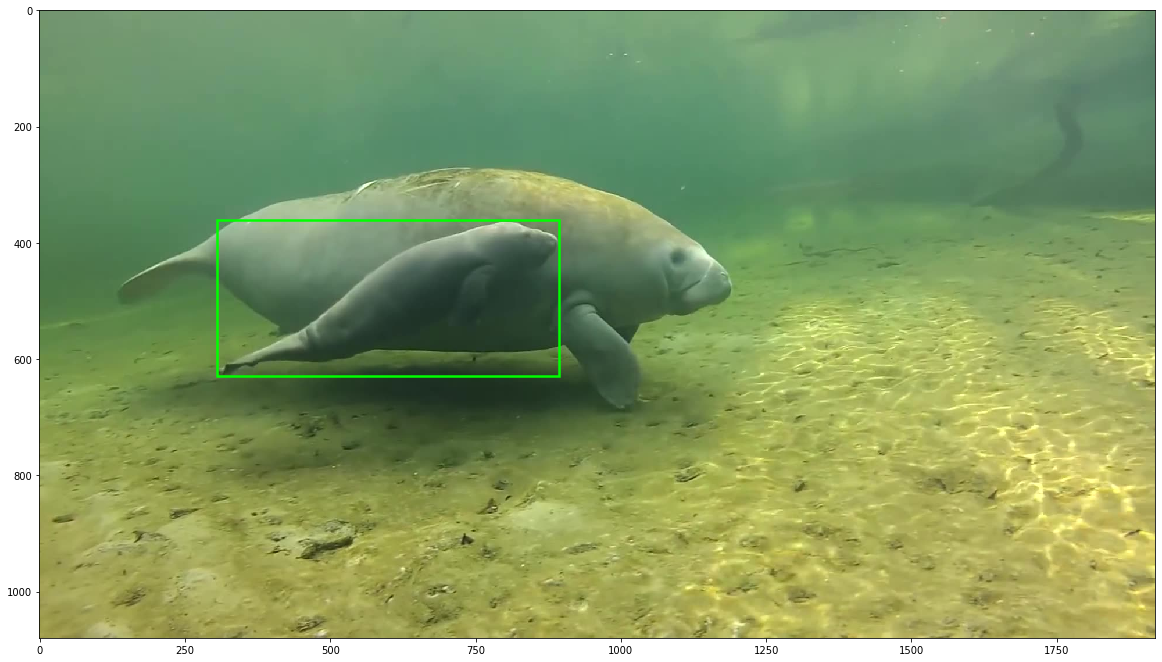

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

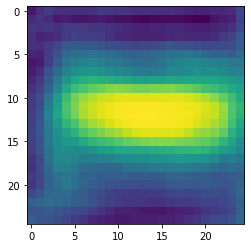

In [12]:
score = res['ctr_rpn'].reshape((25, 25))
plt.imshow(score)
plt.savefig('./result_images/{}/score_{:04d}.png'.format(test_name, ii))
# plt.close('all')

In [15]:
res['bbox']

[1124.1264709554084, 1100.5304223544738, 583.0244018391833, 274.61713380667726]

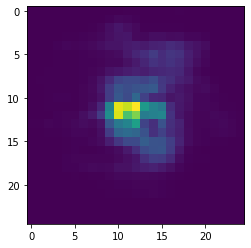

In [36]:
ctr = res['centerness'].reshape((25, 25))
plt.imshow(ctr)
# plt.savefig('./result_images/{}/pscore_{:04d}.png'.format(test_name, ii))